In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import *

In [2]:
train = np.loadtxt('/Users/gost1/Desktop/Machine Vision/digit-recognizer/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('/Users/gost1/Desktop/Machine Vision/digit-recognizer/test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [4]:
test_img.shape

(28000, 28, 28)

In [5]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

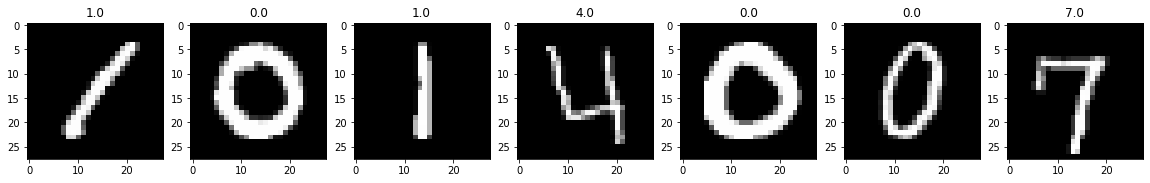

In [6]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:7], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля


In [7]:
# вычисление градиента для тренировочной выборки
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [8]:
# вычисление градиента для тестовой выборки
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [9]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [10]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

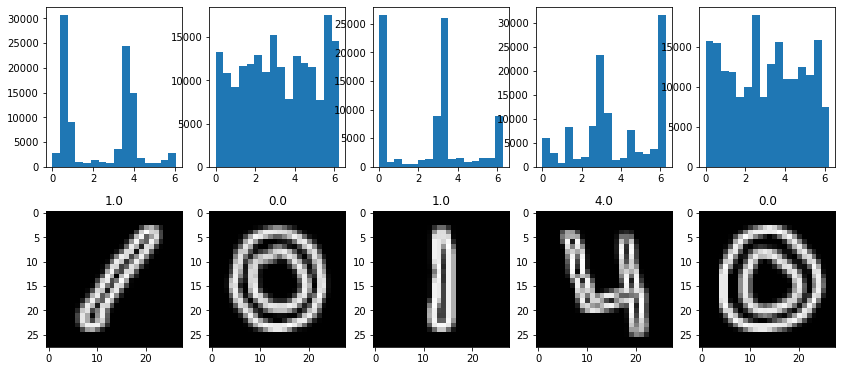

In [11]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Визуализируем гистрограмму градиентов


In [12]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [13]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

In [14]:
train_hist

array([[ 4234.7295517 , 32397.53503449,  6136.26105628, ...,
         1035.53657589,  1231.67667896,  2017.77946831],
       [13269.9921675 , 11440.50674334,  8573.86296946, ...,
         5416.78197719, 18729.0805874 , 13122.59190703],
       [26612.9628557 ,   876.76623234,  1325.44308256, ...,
         1505.98225524,  1458.7033229 ,  8909.06028693],
       ...,
       [12683.2404066 , 26888.77327523,  3684.66196123, ...,
         2238.91177423,  4008.89528338,  4804.64500571],
       [13073.50082825, 24833.85122397, 11954.41843781, ...,
         2275.52706592,  6220.33492209,  2797.80430458],
       [16488.88152543,  8995.74406375, 12515.99691959, ...,
         4144.75091715,  4123.45024246,  6049.34519246]])

## Нормируем вектор гистограммы


In [58]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [59]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

# PCA

In [61]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [66]:
sc = StandardScaler()
X_scaled = sc.fit_transform(train_img.reshape(-1, 28 * 28))
pca = PCA(n_components=38)
X_pca1 = pca.fit_transform(X_scaled)

# Get the transformed dataset
X_pca = pd.DataFrame(X_pca1)
print(X_pca.shape)

(42000, 38)


## Разбиваем выборку на обучение и валидацию

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, train_label, test_size=0.20, random_state=42)

In [68]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [69]:
pred = model.predict(X_test)

In [70]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_test, pred))

Accuracy: 0.8835714285714286


In [71]:
sc = StandardScaler()
X_scaled = sc.fit_transform(test_img.reshape(-1, 28 * 28))
pca = PCA(n_components=38)
X_pca1 = pca.fit_transform(X_scaled)

# Get the transformed dataset
X_pca = pd.DataFrame(X_pca1)
print(X_pca.shape)

(28000, 38)


In [73]:
pred_t = model.predict(X_pca)

In [76]:
with open('submit.csv', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_t, 1):
        dst.write('%s,%s\n' % (i, int(p)))

In [75]:
len(pred_t)

28000